In [52]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [53]:
bag = rosbag.Bag('/home/uware/rosbags/static/rotation/36h11/s_yaw_36h11_5m_1080_20.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60]

In [54]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [55]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,4.057683
1,1.715592,-9.830394
2,2.589771,-12.357628
3,3.381710,-11.623967
4,4.249847,-12.125546
...,...,...
199,71.801831,57.467755
200,72.095031,57.482953
201,72.369035,57.515708
202,72.679796,57.592635


<AxesSubplot:xlabel='relative_time'>

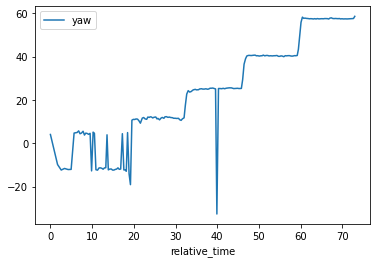

In [56]:
# initial graph
df.plot(x='relative_time', y=target)

In [57]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 5)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [58]:
# the amount of data points we are left with
len(x[peaks])

51

In [59]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

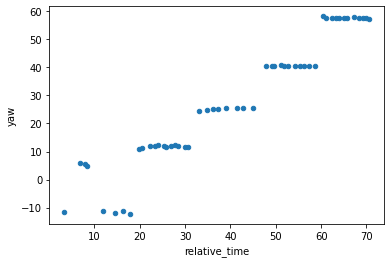

In [60]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [61]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,yaw,true_yaw
3,3.381710,-11.623967,0
8,6.773787,5.724624,15
11,7.833658,5.549702,15
13,8.472057,4.680466,15
23,11.969121,-11.337656,0
31,14.592216,-11.875811,0
36,16.200197,-11.349973,0
41,17.933762,-12.303687,0
47,19.880874,11.038751,15
49,20.553626,11.230039,15


In [62]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [63]:
# remove huge errors because theyre actually wrongly binned
# df_filtered_by_targets = df_filtered_by_targets.drop(df_filtered_by_targets[df_filtered_by_targets['error'].abs()>10].index)

In [64]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [65]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,yaw,true_yaw,error
3,3.381710,-11.623967,0,11.623967
8,6.773787,5.724624,15,9.275376
11,7.833658,5.549702,15,9.450298
23,11.969121,-11.337656,0,11.337656
86,33.043508,24.294146,30,5.705854
90,34.728550,24.899202,30,5.100798
126,47.780819,40.574972,45,4.425028
130,49.093894,40.694736,45,4.305264
164,60.432867,58.240043,60,1.759957
166,61.058567,57.790399,60,2.209601


In [66]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,5.0,11.698219,0.404637,11.337656,11.349973,11.623967,11.875811,12.303687
15,15.0,4.501399,2.714279,2.706618,2.895060,3.440548,3.865605,10.319534
30,8.0,4.827642,0.416613,4.404218,4.585656,4.726836,4.904884,5.705854
45,11.0,4.486584,0.112017,4.286629,4.440298,4.535436,4.559160,4.636748
60,12.0,2.346400,0.226826,1.759957,2.337882,2.424799,2.468754,2.553909


In [67]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

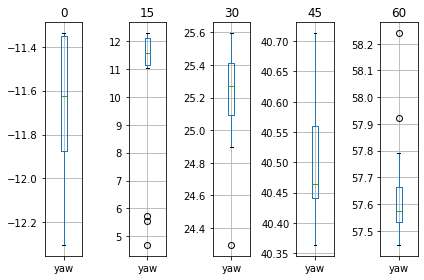

In [68]:
box_plotter(target)

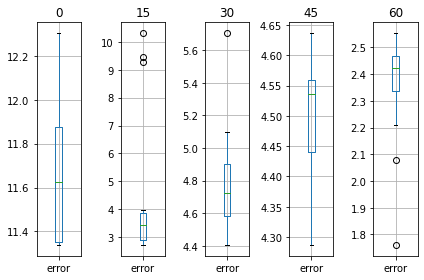

In [69]:
box_plotter('error')

In [70]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_filtered_by_targets)

,relative_time,yaw,true_yaw,error
3,3.381710,-11.623967,0,11.623967
8,6.773787,5.724624,15,9.275376
11,7.833658,5.549702,15,9.450298
13,8.472057,4.680466,15,10.319534
23,11.969121,-11.337656,0,11.337656
31,14.592216,-11.875811,0,11.875811
36,16.200197,-11.349973,0,11.349973
41,17.933762,-12.303687,0,12.303687
47,19.880874,11.038751,15,3.961249
49,20.553626,11.230039,15,3.769961
